In [1]:
import numpy as np
from scipy import *
from pylab import *
import os
import pickle

%matplotlib inline

In [2]:
# folder_Pk = '/global/cscratch1/sd/jialiu/CAMELS/Pk/' ### original, unorganized Pk
folder_Pk = '/pscratch/sd/j/jialiu/CAMELS/Pk/'
home = '/global/homes/j/jialiu/cosmo_dep_feedback/'

In [3]:
### fixed parameters: 
Omega_b = 0.049
h = 0.6711
ns = 0.9624
w = -1
mnu = 0.0 #eV
Omega_k = 0.0

In [8]:
######### get k, which is the same for all sims and all redshift, I think..
# k=np.loadtxt(home+'CAMELS/Pk/IllustrisTNG/LH_0/Pk_m_z=0.00.txt').T[0]
# np.save(home+'Pk/IllustrisTNG_k_m_z=0.00.npy', k)

kmax=30
k=np.load(home+'Pk/IllustrisTNG_k_m_z=0.00.npy')
Nk=sum(k<kmax)
kcut=k[:Nk]
print (Nk)
labels=[r'$\Omega_m$', r'$\sigma_8$', '$log_{10}(A_1)$', '$log_{10}(A_2)$', '$log_{10}(A_3)$', '$log_{10}(A_4)$']

### organize the files
def organize_Pk (iz, isim, iPk='Pk_m', iset='1P'):
    
    # if isim == 'Astrid':
    #     ifn_param=home+'params/params_1P.txt'
    # else:
    ifn_param=home+'params/CosmoAstroSeed_%s.txt'%(isim)
    sim_name = np.loadtxt(ifn_param, usecols=(0), dtype='U') ## the simulation names, e.g. "1P_1_n5"
    sim_params = np.loadtxt(ifn_param, usecols=range(1,7)) ## the actual parameters, corresponding to the sim names above
    #### change all the baryon parameters to log
    sim_params = concatenate([sim_params[:,:2], log10(sim_params[:,2:])],axis=1)
    idx = where(np.char.find(sim_name, iset)!=-1)
    sim_name = sim_name[idx]
    sim_params = sim_params[idx]
    
    #### load all the Pk in next line, takes long time
    Pk_arr = array([np.loadtxt(folder_Pk+'%s/%s/%s/%s_z=%.2f.txt'%(isim, iLH[:2], iLH, iPk, iz))[:Nk] for iLH in sim_name])
    if iPk=='Pk_m': ## no Pk_c/b/g for _DM runs, so we only process _DM once here, when we process Pk_m
        Pk_DM_arr = array([np.loadtxt(folder_Pk+'%s_DM/%s/%s/%s_z=%.2f.txt'%(isim, iLH[:2], iLH, iPk, iz))[:Nk] for iLH in sim_name])
    
    # for iset in ('1P', ): ##('LH', '1P', 'CV'): ##
    idx = where(np.char.find(sim_name, iset)!=-1)
    ifn=home+'Pk/%s_%s_%s_z=%.2f.npy'%(isim, iPk, iset, iz)
    data_arr = concatenate([sim_params[idx], Pk_arr[idx][:,:,1]],axis=1) ## include params and Pk
    save(ifn, data_arr)
    if iPk=='Pk_m': 
        ifn_DM=home+'Pk/%s_%s_%s_z=%.2f_DM.npy'%(isim, iPk, iset, iz)
        data_DM_arr = concatenate([sim_params[idx], Pk_DM_arr[idx][:,:,1]],axis=1) ## include params and Pk
        save(ifn_DM, data_DM_arr)

    print ('%s, %s set has %i models, data shape %s'%(isim, iset, len(idx), data_arr.shape))

118


In [12]:
######## all CAMELS sims
sim_arr = ['Astrid',] ##'IllustrisTNG',  'SIMBA']  #,  ## seems like Astrid files are there, but naming system is different

######### the redshift we're interested in
# zarr=[0.00, 1.05, 2.00, 3.00] #, 0.05, 0.10, 0.15] #
zarr=[3.00,]
####### organize the files, take long #########
for isim in sim_arr:
    for iz in zarr:
        print (isim, iz)
        organize_Pk (iz, isim, iPk='Pk_m')
        organize_Pk (iz, isim, iPk='Pk_g')
        organize_Pk (iz, isim, iPk='Pk_c')


Astrid 3.0
Astrid, 1P set has 1 models, data shape (66, 124)
Astrid, 1P set has 1 models, data shape (66, 124)
Astrid, 1P set has 1 models, data shape (66, 124)


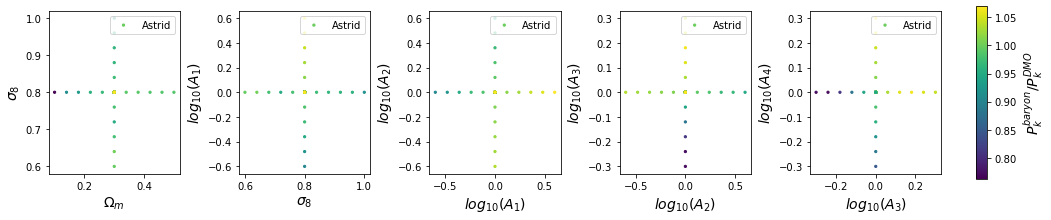

In [14]:
########### validate the tests
iPk = 'Pk_m'
iz = 0
iset = '1P' #LH
isim = 'Astrid' #'IllustrisTNG'

for isim in sim_arr:
    ifn = home+'Pk/%s_%s_%s_z=%.2f.npy'%(isim, iPk, iset, iz)
    ifn_DM=home+'Pk/%s_%s_%s_z=%.2f_DM.npy'%(isim, 'Pk_m', iset, iz)
    Pk_arr = np.load(ifn)
    Pk_DM_arr = np.load(ifn_DM)
    Pk_arr.shape

    params = Pk_arr[:, :6]
    r = Pk_arr[:, 6:]/Pk_DM_arr[:, 6:]
    rprox = mean(r[:, 5:20],axis=1)
    # params.shape, r.shape, rprox.shape

    f, ax=subplots(1,5, figsize=(16,3))

    for i in range(5):
        im=ax[i].scatter(params.T[i], params.T[i+1], c=rprox, label=isim, s=5)
        ax[i].set_xlabel(labels[i], fontsize=14)
        ax[i].set_ylabel(labels[i+1],fontsize=14)   
        ax[i].legend()
    cbar_ax = f.add_axes([0.93, 0.1, 0.01, 0.8])
    f.colorbar(im, cax=cbar_ax)
    f.subplots_adjust(wspace=0.45)
    cbar_ax.set_ylabel(r'$P_k^{baryon}/P_k^{DMO}$',fontsize=14)
    show()

In [15]:
k[5:20]

array([1.6191547 , 1.87068667, 2.12329004, 2.37814498, 2.63048993,
       2.87865316, 3.13114437, 3.38815958, 3.63874185, 3.88831591,
       4.13905216, 4.39030578, 4.64217234, 4.89467867, 5.14726905])